In [27]:
"""
https://mirror-feeling-d80.notion.site/Workflow-And-Agents-17e808527b1780d792a0d934ce62bee6
"""

from langchain_openai import AzureOpenAI, AzureChatOpenAI
import os
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display



In [ ]:
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model="gpt-4o-mini"
)

## Augmented LLM

### Structured Output

In [12]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("Find out about microsoft's latest news")
print(output.search_query)
print(output.justification)

Microsoft latest news
To get the most recent updates and announcements from Microsoft.


### Tool Call

In [22]:
def multiply_1(a: int, b: int) -> int:
    """This functions adds integers"""
    return a * b

def multiply_2(a: int, b: int) -> int:
    """This functions multiplies integers"""
    return a * b

def add(a:int, b:int)->int:
    return a+b

llm_with_tools = llm.bind_tools([multiply_2,multiply_1, add])

msg = llm_with_tools.invoke("What is 2 times 3?")

msg.tool_calls

[{'name': 'multiply_2',
  'args': {'a': 2, 'b': 3},
  'id': 'call_tRT3in62pm965CnpUoco2Y3D',
  'type': 'tool_call'}]

## Workflow Patterns

### Prompt Chaining

In [24]:
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [25]:
# nodes in graph
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [26]:
# Gate check
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

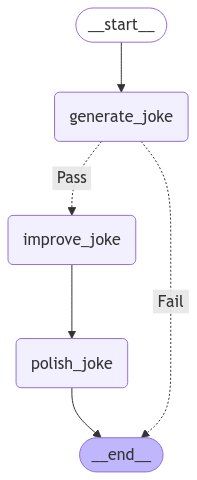

In [28]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))


In [29]:
state = chain.invoke({"topic": "cats"})
state

{'topic': 'cats',
 'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse! 🐱💻',
 'improved_joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse—after all, it heard there were some "purr-suasive" deals online! 🐱💻',
 'final_joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse—after all, it heard there were some "purr-suasive" deals online! But little did it know, the mouse was actually a tech-savvy hacker planning to launch a catnip-themed cryptocurrency! 🐱💻💰'}

In [30]:
state = chain.invoke({"topic": "windows 11"})
state

{'topic': 'windows 11',
 'joke': 'Why did Windows 11 go to therapy? \n\nBecause it couldn’t stop crashing whenever it faced a problem!',
 'improved_joke': 'Why did Windows 11 go to therapy? \n\nBecause it couldn’t stop crashing whenever it faced a problem—it just couldn’t handle the “pressure” and needed to “update” its emotional drivers!',
 'final_joke': 'Why did Windows 11 go to therapy? \n\nBecause it couldn’t stop crashing whenever it faced a problem—it just couldn’t handle the “pressure” and needed to “update” its emotional drivers! But in a shocking twist, it discovered that the real issue was its toxic friendship with Internet Explorer, who kept dragging it down with outdated baggage!'}

### Parallelization

In [32]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [33]:
# nodes as functions

def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

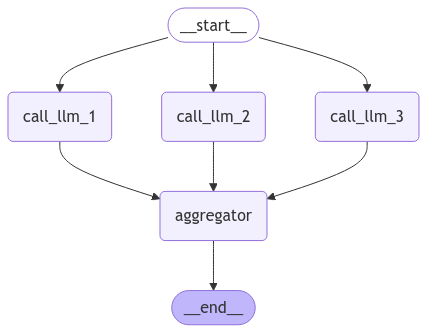

In [34]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [35]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
**The Secret Council of Whiskers**

In a cozy little town called Felinshire, where the sun always seemed to shine and every garden had a patch of soft grass, lived a group of cats who were not just ordinary felines. These cats were the revered members of the Secret Council of Whiskers, a group dedicated to maintaining peace and harmony among the feline community.

The council's headquarters was a grand old oak tree in the heart of Felinshire Park. Its thick trunk was hollowed out, creating a perfect meeting space adorned with soft moss and the occasional feather. The council convened every full moon, and it was during one such meeting that a pressing issue arose.

Whiskers, the wise old tabby with a tufted ear, scratched his chin thoughtfully. “The humans are planning to expand the park and build a new playground. We must ensure they don’t disturb our territory!”

Mittens, a fluffy calico with a penchant for mischief, chimed in excited

### Routing

In [36]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [37]:
class State(TypedDict):
    input: str
    decision: str
    output: str

In [38]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

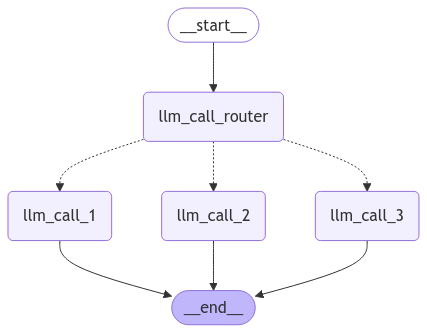

In [39]:
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [40]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!
